# Mass Spring System

In [12]:
# We define the mass spring system as follows:
class Spring():
    def __init__(self, k=2.5, m=1.5, g=9.81):
        self.k = k # spring stiffness
        self.m = m # mass
        self.g = g # gravitational constant
        
    def deriv(self, state, t):
        # State equals [y, dy], derivative returns [dy, ddy]
        ddy = ((-self.k * state[0]) / self.m) + self.g
        return [state[1], ddy]

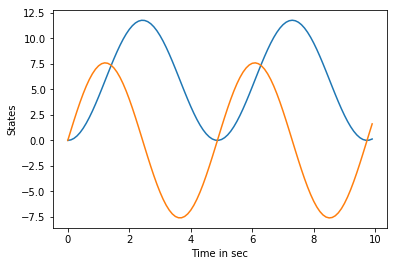

In [13]:
# We can integrate the system from starting point using scipy.integrate
from scipy.integrate import odeint
import numpy as np

# Define the dynamical system we want to estimate
system = Spring()
t = np.arange(0.0, 10.0, 0.1)
y0 = [0.0, 0.0]
y = odeint(system.deriv, y0, t)

# Make plots
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(t, y)
plt.xlabel('Time in sec')
plt.ylabel('States')
plt.show()

## Training
We train 2 models:
- Unstabilized model using regular training
- Stabilized model using Lyapunov exponent regularization

In [4]:
# We now want to learn system behavior from the data
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.integrators.simple import Euler, K2K3L2DistRungeKutta4

# Make tensors
tt = torch.tensor(t, dtype=torch.float).reshape(-1, 1)
yt = torch.tensor(y, dtype=torch.float).reshape(-1, 2)

# The model parameterizes the gradient
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.output = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, y):
        return self.output(y)
    
def batch_normalize(p):
    # Norms along batch size
    return p / torch.norm(p.view(p.size(0), -1), p=2, dim=1)[:, None]

def random_norm_vec(y):
    return batch_normalize(torch.randn_like(y))

method = K2K3L2DistRungeKutta4

# Make two models (undefended and defended)
model1 = Model(2, 64, 2)
model1.optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9) 

model2 = Model(2, 64, 2)
model2.optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9) 

model3 = Model(2, 64, 2)
model3.optimizer = torch.optim.SGD(model3.parameters(), lr=0.01, momentum=0.9) 

# Define training settings
def train_models(model1, model2, model3, K, L, scale, le_reg, steps=2000, verbose=False):
    # Best score
    scores, states = [1e10, 1e10, 1e10], [{}, {}, {}]
    for s in range(steps):
        # Make a batch of trajectories
        t0, t1 = tt[:-1], tt[1:]
        y0, y1 = yt[:-1], yt[1:]

        # Training model 1
        y1_pred,_ = method.step(model1, t0, t1 - t0, y0)
        loss1 = torch.sum((y1_pred - y1) ** 2) 
        model1.optimizer.zero_grad()
        loss1.backward()
        model1.optimizer.step()

        # Training model 2
        y1_pred,_ = method.step(model2, t0, t1 - t0, y0)

        # Generate perturbations according to the total norm
        eps = torch.norm(y0, p=2, dim=1).mean() * scale

        # Init K random perturbations
        vecs = [random_norm_vec(y0) for _ in range(K)]
        exp = 0
        for l in range(L):
            # Perturbate trajectory
            y0_per = [y0 + eps * vecs[i] for i in range(K)]

            # Take step for each trajectory
            y1_per = [method.step(model2, t0, t1 - t0, y0_p)[0] for y0_p in y0_per]

            # Model divergence (+ subtract projection)
            for i in range(K):
                diff = y1_per[i] - y1_pred
                proj = sum([vecs[j] * (diff * vecs[j]).sum(-1)[:, None] for j in range(0, i)])
                diff = diff - proj

                # Rescale vectors before last loop L
                if l < L - 1:
                    vecs[i] = batch_normalize(diff).detach()
                else:
                    exp += torch.log(torch.norm(diff, p=2, dim=1) / eps + 1e-10).mean() / K

        # Optimize
        loss2 = torch.sum((y1_pred - y1) ** 2) 
        le_loss = exp
        model2.optimizer.zero_grad()
        (loss2 + le_reg * le_loss).backward()
        model2.optimizer.step()
        
        # Training model 3
        k2k3div = 0
        y1_pred, div = method.step(model3, t0, t1 - t0, y0)
        k2k3div += div
        
        # Optimize
        loss3 = torch.sum((y1_pred - y1) ** 2) 
        model3.optimizer.zero_grad()
        (loss3 + 10 * le_reg * k2k3div).backward()
        model3.optimizer.step()
        
        # Checkpoint best models
        losses, models = [loss1.item(), (loss2 + le_reg * le_loss).item(), (loss3 + 1e-3 * k2k3div).item()], [model1, model2, model3]
        for i in range(3):
            if losses[i] < scores[i]:
                scores[i] = losses[i]
                states[i] = models[i].state_dict()
        
        if verbose:
            print("Loss model1", loss1.item(), "Loss model2", loss2.item(), "Lyapunov exponent:", le_loss.item(), "Loss model3", loss3.item(), "RK :", k2k3div.item())
    # Redo best model
    for m, s in zip(models, states):
        m.load_state_dict(s)
    return model1, model2, model3

model1, model2, model3 = train_models(model1, model2, model3, K=1, L=10, scale=0.5, le_reg=1, steps=2000, verbose=True)

Loss model1 77.72333526611328 Loss model2 76.73571014404297 Lyapunov exponent: 0.00114541279617697 Loss model3 76.49998474121094 RK : 8.309892109537032e-06
Loss model1 63.42491149902344 Loss model2 62.03316879272461 Lyapunov exponent: 0.0016493233852088451 Loss model3 64.10884857177734 RK : 6.415430107153952e-05
Loss model1 46.076717376708984 Loss model2 43.462005615234375 Lyapunov exponent: 0.0009215414174832404 Loss model3 47.907127380371094 RK : 0.0012247181730344892
Loss model1 33.4731330871582 Loss model2 31.513853073120117 Lyapunov exponent: 0.006128787528723478 Loss model3 33.313133239746094 RK : 0.008618800900876522
Loss model1 27.72580909729004 Loss model2 28.550392150878906 Lyapunov exponent: 0.012832330539822578 Loss model3 23.90826988220215 RK : 0.03265492618083954
Loss model1 22.31911277770996 Loss model2 22.796924591064453 Lyapunov exponent: 0.029912371188402176 Loss model3 18.727102279663086 RK : 0.06893312186002731
Loss model1 13.092443466186523 Loss model2 13.071675300

In [5]:
def validate_model(model1, model2, model3, step_size=0.01, t1=30, plot=False, runs=10, norm=0.5):
    t = np.arange(0.0, t1, step_size)
    mse1, mse2, mse3 = 0, 0, 0
    for u in range(runs):
        random = torch.randn(size=[2])
        y0 = norm * random / torch.norm(random)
        y = odeint(system.deriv, y0, t)
        yt = torch.tensor(y, dtype=torch.float)
        yp1, yp2, yp3 = torch.zeros_like(yt), torch.zeros_like(yt), torch.zeros_like(yt)
        yp1[0, :], yp2[0, :], yp3[0, :] = y0, y0, y0
        for i in range(len(t) - 1):
            yp1[i + 1],_ = method.step(model1, t[i], t[i + 1] - t[i], yp1[i])
            yp2[i + 1],_ = method.step(model2, t[i], t[i + 1] - t[i], yp2[i])
            yp3[i + 1],_ = method.step(model3, t[i], t[i + 1] - t[i], yp3[i])
            
        # Calculate error
        mse1 += ((yp1 - yt) ** 2).mean().item() / runs
        mse2 += ((yp2 - yt) ** 2).mean().item() / runs
        mse3 += ((yp3 - yt) ** 2).mean().item() / runs
        
        if plot:
            plt.plot(t, y[:, 0])
            plt.plot(t, yp1[:, 0].detach().numpy())
            plt.plot(t, yp2[:, 0].detach().numpy())
            plt.plot(t, yp3[:, 0].detach().numpy())
            plt.xlabel('Time (sec)')
            plt.ylabel('States')
            plt.legend(('Real', 'Unstabilized', 'Lyapunov', 'Runge-Kutta'))
            plt.savefig('figs/MassSpring-Norm{n}-Run{u}.png'.format(n=norm, u=u))
            plt.show()
    
    print("Mean squared error for model 1: ", mse1, ", for model 2: ", mse2, " and for model 3: ", mse3)
    return mse1, mse2, mse3

In [12]:
def train_and_validate(scale, le_reg):
    # Make two models (undefended and defended)
    m1 = Model(2, 64, 2)
    m1.optimizer = torch.optim.SGD(m1.parameters(), lr=0.01, momentum=0.9) 

    m2 = Model(2, 64, 2)
    m2.optimizer = torch.optim.SGD(m2.parameters(), lr=0.01, momentum=0.9) 
    
    m3 = Model(2, 64, 2)
    m3.optimizer = torch.optim.SGD(m3.parameters(), lr=0.01, momentum=0.9) 

    # Train models
    m1, m2, m3 = train_models(m1, m2, m3, K=1, L=10, scale=scale, le_reg=le_reg, steps=2000, verbose=False)

    # Validate models
    mse1, mse2, mse3 = validate_model(m1, m2, m3, runs=20, norm=0.5)
    return m1, m2, m3, mse1, mse2, mse3

le_regs=[10, 1, 1e-1, 1e-2]
best_mse2, best_mse3 = 1e10, 1e10

# Find the right scale
for le_reg in le_regs:
    print("Regularization:", le_reg)
    model1, model2, model3, mse1, mse2, mse3 = train_and_validate(scale=0.5, le_reg=le_reg)
    if mse2 < best_mse2:
        best_mse = mse2
        best_model1, best_model2 = model1.state_dict(), model2.state_dict()
    if mse3 < best_mse3:
        best_mse = mse3
        best_model3 = model3.state_dict()

Regularization: 10
Mean squared error for model 1:  42.750680196285245 , for model 2:  3.501129168272019  and for model 3:  26.087368202209472
Regularization: 1
Mean squared error for model 1:  42.583225274086004 , for model 2:  1.5801990747451784  and for model 3:  15.483802795410153
Regularization: 0.1
Mean squared error for model 1:  21.263815325498584 , for model 2:  19.590868175029755  and for model 3:  19.771590375900267
Regularization: 0.01
Mean squared error for model 1:  46.03860325813293 , for model 2:  38.586267116665844  and for model 3:  52.777971339225765


In [14]:
#Load best model
model1.load_state_dict(best_model1)
model2.load_state_dict(best_model2)
model3.load_state_dict(best_model3)

In [14]:
#Check multiple norms
norms = [1, 0.5, 1e-1, 1e-2, 0]
for norm in norms:
    print("Norm:", norm)
    _,_,_ = validate_model(model1, model2, model3, runs=20, norm=norm)

Norm: 1
Mean squared error for model 1:  59.547243881225576 , for model 2:  50.16015938520432  and for model 3:  50.85376977920532
Norm: 0.5
Mean squared error for model 1:  43.69095570892095 , for model 2:  29.6206406400539  and for model 3:  52.90317416600882
Norm: 0.1
Mean squared error for model 1:  34.4701862975955 , for model 2:  1.4841690979199482  and for model 3:  13.023866092320533
Norm: 0.01
Mean squared error for model 1:  0.4241597546264529 , for model 2:  0.012457104196073487  and for model 3:  0.12313282678369433
Norm: 0
Mean squared error for model 1:  0.007738698273897174 , for model 2:  0.0049977651797235  and for model 3:  0.004814750049263237


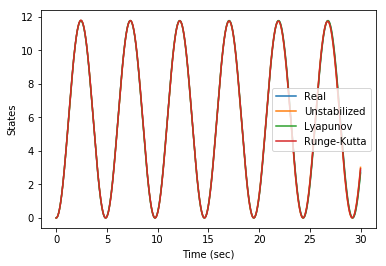

Mean squared error for model 1:  0.007738698273897171 , for model 2:  0.004997765179723501  and for model 3:  0.004814750049263239


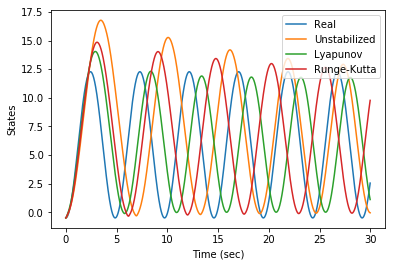

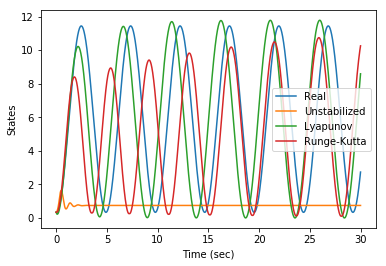

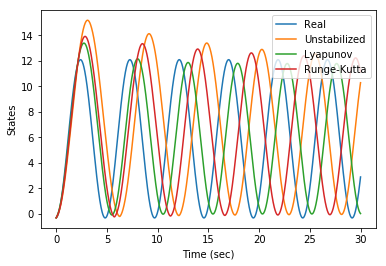

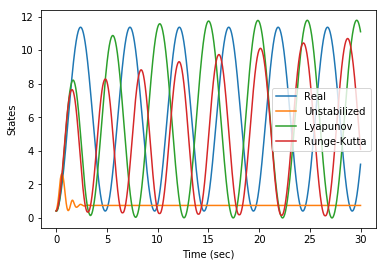

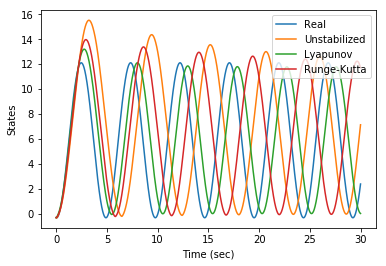

Mean squared error for model 1:  50.15667572021484 , for model 2:  35.23261985778809  and for model 3:  58.46000823974609


(50.15667572021484, 35.23261985778809, 58.46000823974609)

In [16]:
validate_model(model1, model2, model3, plot=True, runs=1, norm=0.0)
validate_model(model1, model2, model3, plot=True, runs=5, norm=0.5)

# Plot phase space

In [56]:
# Make perturbed points
norm, runs = 0.5, 5
randoms = [torch.randn(size=[2]) for _ in range(runs)]
y0s = [norm * r / torch.norm(r) for r in randoms]

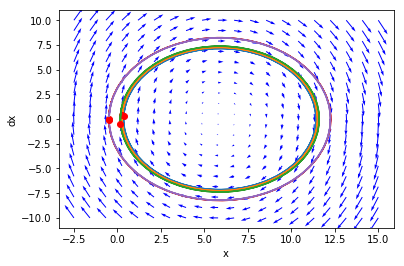

In [59]:
# Make quiver plot
X, DX = np.meshgrid(np.linspace(-2.5, 15.0, 20), np.linspace(-10, 10, 20))
u, v = np.zeros(X.shape), np.zeros(DX.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = X[i, j]
        dx = DX[i, j]
        u[i,j], v[i,j] = system.deriv([x, dx], None)
Q = plt.quiver(X, DX, u, v, color='b')

# Plot lines / point
for y0 in y0s:
    y = odeint(system.deriv, y0, t)
    plt.plot(y[:,0], y[:,1]) # path
    plt.plot([y[0,0]], [y[0,1]], 'ro') # start

#plt.legend(loc='lower right')
plt.xlabel('x')
plt.ylabel('dx')
#plt.xlim([-2., 8.])
#plt.ylim([-3., 3.])
plt.savefig('figs/MassSpringPhaseReal.png')
plt.show()

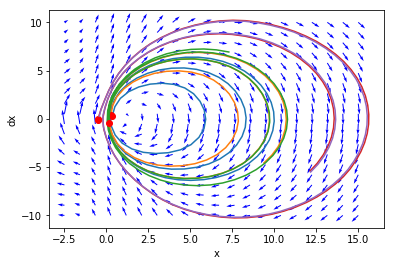

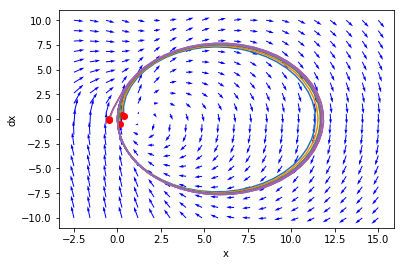

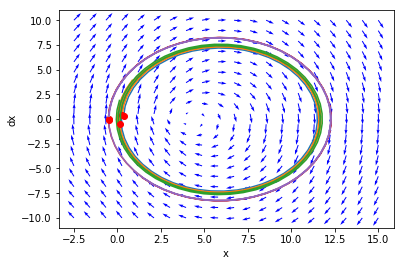

In [60]:
models = [model1, model2, model3]
for model in models:
    # Make quiver plot
    X, DX = np.meshgrid(np.linspace(-2.5, 15.0, 20), np.linspace(-10, 10, 20))
    u, v = np.zeros(X.shape), np.zeros(DX.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = X[i, j]
            dx = DX[i, j]
            u[i,j], v[i,j] = model(t=0, y=torch.tensor([x, dx]))
    Q = plt.quiver(X, DX, u, v, color='b')
    
    # Plot lines / point
    for y0 in y0s:
        y = odeint(system.deriv, y0, t)
        yt = torch.tensor(y, dtype=torch.float)
        yp = torch.zeros_like(yt)
        yp[0, :] = y0
        for i in range(len(t) - 1):
            yp[i + 1],_ = method.step(model, t[i], t[i + 1] - t[i], yp[i])
    
        yp = yp.detach().numpy()
        plt.plot(yp[:,0], yp[:,1]) # path
        plt.plot([yp[0,0]], [yp[0,1]], 'ro') # start

    plt.xlabel('x')
    plt.ylabel('dx')
    plt.savefig('figs/MassSpringPhaseModel{model_num}.png'.format(model_num=models.index(model)))
    plt.show()